In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path 
from collections import Counter 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers



## Google OCR API, keras-ocr, Tesseract로 테스트 진행

### Google OCR API

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [3]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/test/2.jpeg'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-rw-r-- 1 aiffel aiffel 2333  3월 11 11:35 /home/aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"YOU'RE NOT LOST
YOU'RE HERE
"

"YOU'RE"

"NOT"

"LOST"

"YOU'RE"

"HERE"
bounds: (715,470),(874,471),(874,504),(715,503)


### keras-ocr

In [7]:
import matplotlib.pyplot as plt
import keras_ocr
from glob import glob

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


In [8]:
image_path = glob(os.getenv('HOME')+'/aiffel/ocr_python/test/*.*')

images = [ keras_ocr.tools.read(url) for url in image_path]
prediction_groups = [pipeline.recognize([url]) for url in image_path]

/home/aiffel/anaconda3/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


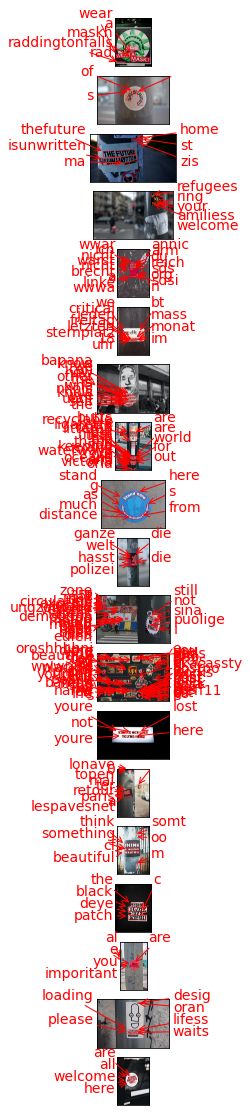

In [9]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [46]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test'
img_file_path = work_dir + '/2.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel/aiffel/ocr_python/test/0000.png
/home/aiffel/aiffel/ocr_python/test/0001.png
/home/aiffel/aiffel/ocr_python/test/0002.png
/home/aiffel/aiffel/ocr_python/test/0003.png
/home/aiffel/aiffel/ocr_python/test/0004.png
/home/aiffel/aiffel/ocr_python/test/0005.png


In [47]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

YOU'RE

NOT

LOST

YOU'RE

FecRE.

prac nen

Done


## 후기

-시작 전에는 퍼실님께서 보너스 노드같은 느낌이라고 하셔서 쉽게 해결할 수 있을 것만 같았는데 생각보다 어려웠다.   
-노드에는 파일을 하나씩만 넣는 경우만 코드로 짜져 있어서 그 코드를 여러 사진 파일을 사용할 수 있게끔 바꿔주는 것이 어려웠다.   
-확실히 Tesseract model이 가장 성능이 안좋은 것 같다.